# 08. PyOD Algorithms Comparison

Compare multiple anomaly detection algorithms using PyOD library:
- **IForest** - Isolation Forest (tree-based)
- **KNN** - K-Nearest Neighbors (distance-based)
- **HBOS** - Histogram-based Outlier Score (very fast)
- **ECOD** - Empirical Cumulative Distribution (parameter-free)
- **COPOD** - Copula-based Outlier Detection (parameter-free)
- **OCSVM** - One-Class SVM (boundary-based)

**Note:** LOF is only available at aggregated level via `AggregatedPyOD` (too slow for 13M tenders).

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers, load_bids
from src.detectors import PyODDetector, compare_algorithms

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-01 11:21:38


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2023], sample_frac=0.05)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2023...
Sampled to 174,587 records (5%)
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 174,587
Buyers: 35,995
Suppliers: 358,376


## 2. Quick Comparison (3 Algorithms)

In [3]:
# Compare IForest, HBOS, ECOD (fast algorithms)
comparison_fast = compare_algorithms(
    tenders,
    algorithms=["iforest", "hbos", "ecod"],
    contamination=0.05,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

print("\n" + "="*60)
print("COMPARISON RESULTS (Fast Algorithms)")
print("="*60)
display(comparison_fast)


PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: HBOS
  Histogram-based Outlier Score - very fast, assumption of independence
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting HBOS...

HBOS complete!
  Anomalies: 8,729 (5.00%)

PyOD Detector: ECOD
  Empirical Cumulative Distribution - unsupervised, parameter-free
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting ECOD...


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.



ECOD complete!
  Anomalies: 8,730 (5.00%)

COMPARISON RESULTS (Fast Algorithms)


[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    1.9s remaining:   11.7s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    1.9s finished


,algorithm,anomalies,anomaly_rate,mean_score,max_score
0,iforest,8730,5.000372,0.172007,1.0
1,hbos,8729,4.999800,0.159032,1.0
2,ecod,8730,5.000372,0.142614,1.0


## 3. Full Comparison (All Algorithms)

In [4]:
# Compare all available algorithms (tender-level, excludes LOF)
all_algorithms = ["iforest", "knn", "hbos", "ecod", "copod", "ocsvm"]

comparison_all = compare_algorithms(
    tenders,
    algorithms=all_algorithms,
    contamination=0.05,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

print("\n" + "="*60)
print("COMPARISON RESULTS (All Tender-Level Algorithms)")
print("="*60)
display(comparison_all)


PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: KNN
  K-Nearest Neighbors - distance-based anomalies
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting KNN...

KNN complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: HBOS
  Histogram-based Outlier Score - very fast, assumption of independence
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting HBOS...

HBOS complete!
  Anomalies: 8,729 (5.00%)

PyOD Detector: ECOD
  Empirical Cumulative Distribution - unsupervised, parameter-free
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
S

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    0.0s finished


  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting COPOD...


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    0.0s finished



COPOD complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: OCSVM
  One-Class SVM - boundary-based detection
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting OCSVM...

OCSVM complete!
  Anomalies: 8,730 (5.00%)

COMPARISON RESULTS (All Tender-Level Algorithms)


,algorithm,anomalies,anomaly_rate,mean_score,max_score
0,iforest,8730,5.000372,0.172007,1.0
1,knn,8730,5.000372,0.006892,1.0
2,hbos,8729,4.999800,0.159032,1.0
3,ecod,8730,5.000372,0.142614,1.0
4,copod,8730,5.000372,0.131820,1.0
5,ocsvm,8730,5.000372,0.299274,1.0


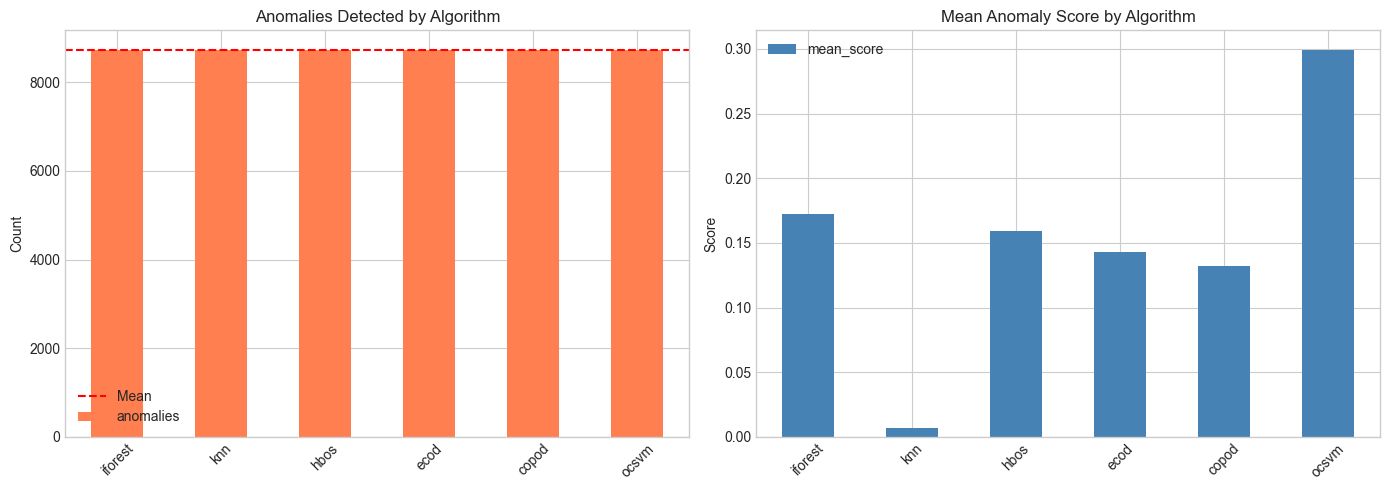

In [5]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Anomaly count
ax1 = axes[0]
comparison_all.plot(kind='bar', x='algorithm', y='anomalies', ax=ax1, color='coral')
ax1.set_title('Anomalies Detected by Algorithm')
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=comparison_all['anomalies'].mean(), color='red', linestyle='--', label='Mean')
ax1.legend()

# Mean score
ax2 = axes[1]
comparison_all.plot(kind='bar', x='algorithm', y='mean_score', ax=ax2, color='steelblue')
ax2.set_title('Mean Anomaly Score by Algorithm')
ax2.set_xlabel('')
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/pyod_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Detailed Analysis with Best Algorithm

In [6]:
# Use Isolation Forest (usually best for tabular data)
detector = PyODDetector(
    algorithm="iforest",
    contamination=0.05,
    random_state=42,
)

results = detector.fit_detect(
    tenders,
    buyers_df=buyers,
    suppliers_df=suppliers,
)

print("\nSummary:")
display(detector.summary())

PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 8,730 (5.00%)

Summary:


,metric,value
0,algorithm,iforest
1,total_tenders,174587
2,anomalies,8730
3,anomaly_rate,5.000372
4,risk_critical,142
5,risk_high,1686
6,risk_medium,9826
7,risk_low,162931


In [7]:
# Risk level distribution
print("Risk Level Distribution:")
print(results['risk_level'].value_counts().sort_index())

Risk Level Distribution:
risk_level
low         162931
medium        9826
high          1686
critical       142
Name: count, dtype: int64


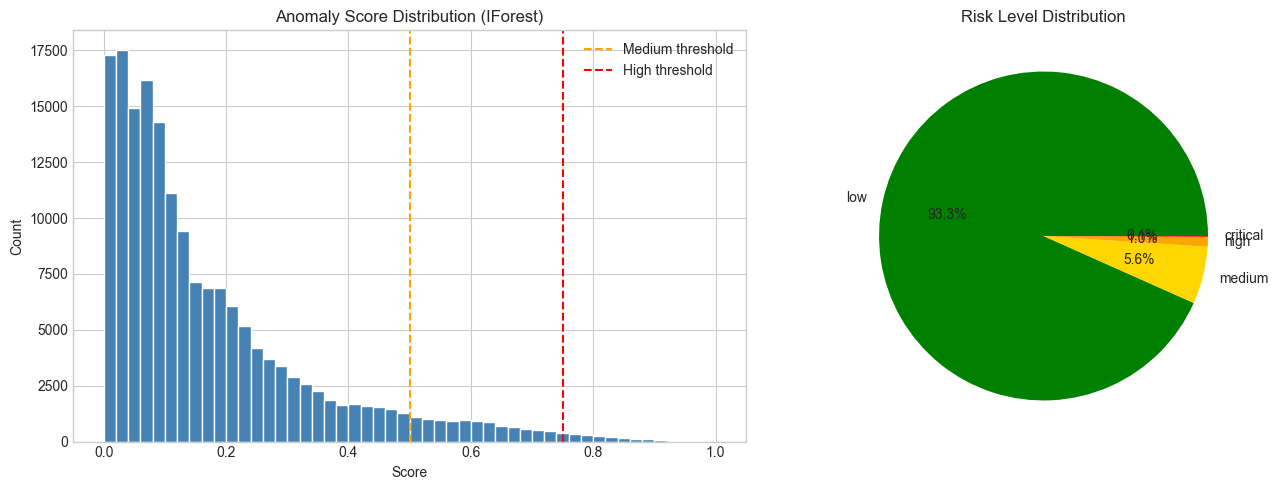

In [8]:
# Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
results['score'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.axvline(x=0.5, color='orange', linestyle='--', label='Medium threshold')
ax1.axvline(x=0.75, color='red', linestyle='--', label='High threshold')
ax1.set_title('Anomaly Score Distribution (IForest)')
ax1.set_xlabel('Score')
ax1.set_ylabel('Count')
ax1.legend()

# Risk level pie
ax2 = axes[1]
risk_counts = results['risk_level'].value_counts()
colors = {'low': 'green', 'medium': 'gold', 'high': 'orange', 'critical': 'red'}
risk_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                 colors=[colors.get(x, 'gray') for x in risk_counts.index])
ax2.set_title('Risk Level Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('../results/pyod_iforest_scores.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. High-Risk Tenders Analysis

In [9]:
# Get high-risk anomalies
high_risk = detector.get_anomalies(min_score=0.75)
print(f"High-risk tenders (score >= 0.75): {len(high_risk):,}")

# Merge with tender details
high_risk_details = high_risk.merge(
    tenders[['tender_id', 'tender_value', 'procurement_method', 'is_single_bidder', 'price_change_pct']],
    on='tender_id'
)

print(f"\nTotal value: {high_risk_details['tender_value'].sum()/1e9:.2f} B UAH")
print(f"Single bidder rate: {high_risk_details['is_single_bidder'].mean()*100:.1f}%")
print(f"\nTop 10 by score:")
display(high_risk_details.nlargest(10, 'score')[['tender_id', 'score', 'risk_level', 'tender_value', 'procurement_method', 'is_single_bidder']])

High-risk tenders (score >= 0.75): 1,828

Total value: 6.54 B UAH
Single bidder rate: 25.9%

Top 10 by score:


,tender_id,score,risk_level,tender_value,procurement_method,is_single_bidder
1216,93c43d3141514adc80b93d6c3f0d440e,1.000000,critical,418450.00,open,0
457,9fadd2741047434188f6bef0c778cc2c,0.988386,critical,674530.00,open,0
977,d8d902c0d45845899dd6eede2d67a971,0.976662,critical,10000.00,selective,0
434,7eef7a0be1a64ece84b1e5f91d94aea2,0.972723,critical,2355000.00,open,0
1435,78a4ce1c1de44ba8ae4586c73b13e8b9,0.971142,critical,511792.67,open,0
20,71cbef69c82549eb9e5c29d63e8df21c,0.969363,critical,26850.00,open,0
437,111e534e755c4e099124cd60b2589176,0.968693,critical,588000.00,open,0
825,b6b48d6d801e44abaa0b368781bbfd32,0.963478,critical,413660.00,selective,0
385,cdb8d5e63ea74b8c913e23604f9e89ba,0.963314,critical,143910.00,open,0
1724,18ddd84e45cf44f2b49e220db4692713,0.962640,critical,37664.00,selective,0


In [10]:
# Procurement method distribution in anomalies
print("Procurement method in high-risk tenders:")
print(high_risk_details['procurement_method'].value_counts(normalize=True).mul(100).round(1))

Procurement method in high-risk tenders:
procurement_method
open         65.5
selective    26.7
limited       7.8
Name: proportion, dtype: float64


## 6. Algorithm Agreement Analysis

In [11]:
# Run multiple algorithms and check overlap
algorithms_to_compare = ["iforest", "hbos", "ecod", "knn"]
all_results = {}

for algo in algorithms_to_compare:
    print(f"\n{'='*60}")
    det = PyODDetector(algorithm=algo, contamination=0.05)
    res = det.fit_detect(tenders, buyers_df=buyers, suppliers_df=suppliers)
    all_results[algo] = set(res[res['anomaly'] == 1]['tender_id'].tolist())


PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: HBOS
  Histogram-based Outlier Score - very fast, assumption of independence
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting HBOS...

HBOS complete!
  Anomalies: 8,729 (5.00%)

PyOD Detector: ECOD
  Empirical Cumulative Distribution - unsupervised, parameter-free
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting ECOD...


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:    1.7s remaining:   10.9s
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:    1.8s finished



ECOD complete!
  Anomalies: 8,730 (5.00%)

PyOD Detector: KNN
  K-Nearest Neighbors - distance-based anomalies
Processing 174,587 tenders...
Step 1/3: Preparing features...
  Features: 14
Step 2/3: Preprocessing...
  Shape: (174587, 14)
Step 3/3: Fitting KNN...

KNN complete!
  Anomalies: 8,730 (5.00%)


In [12]:
# Calculate overlap
from itertools import combinations

print("\nPairwise Agreement (Jaccard similarity):")
print("="*50)

for algo1, algo2 in combinations(algorithms_to_compare, 2):
    set1 = all_results[algo1]
    set2 = all_results[algo2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union > 0 else 0
    print(f"{algo1:8} vs {algo2:8}: {jaccard:.3f} ({intersection:,} common anomalies)")


Pairwise Agreement (Jaccard similarity):
iforest  vs hbos    : 0.601 (6,554 common anomalies)
iforest  vs ecod    : 0.768 (7,585 common anomalies)
iforest  vs knn     : 0.543 (6,146 common anomalies)
hbos     vs ecod    : 0.613 (6,637 common anomalies)
hbos     vs knn     : 0.470 (5,583 common anomalies)
ecod     vs knn     : 0.555 (6,234 common anomalies)


In [13]:
# Consensus anomalies (flagged by 3+ algorithms)
from collections import Counter

all_anomalies = []
for algo, ids in all_results.items():
    all_anomalies.extend(ids)

anomaly_counts = Counter(all_anomalies)
consensus_3plus = [tid for tid, count in anomaly_counts.items() if count >= 3]
consensus_all = [tid for tid, count in anomaly_counts.items() if count == len(algorithms_to_compare)]

print(f"\nConsensus Analysis:")
print(f"  Flagged by 3+ algorithms: {len(consensus_3plus):,}")
print(f"  Flagged by ALL algorithms: {len(consensus_all):,}")


Consensus Analysis:
  Flagged by 3+ algorithms: 7,437
  Flagged by ALL algorithms: 4,860


In [14]:
# Analyze consensus anomalies
if consensus_all:
    consensus_df = tenders[tenders['tender_id'].isin(consensus_all)].copy()
    print(f"\nConsensus anomalies (flagged by all {len(algorithms_to_compare)} algorithms):")
    print(f"  Count: {len(consensus_df):,}")
    print(f"  Total value: {consensus_df['tender_value'].sum()/1e9:.2f} B UAH")
    print(f"  Single bidder rate: {consensus_df['is_single_bidder'].mean()*100:.1f}%")
    print(f"\n  Procurement methods:")
    print(consensus_df['procurement_method'].value_counts())


Consensus anomalies (flagged by all 4 algorithms):
  Count: 4,860
  Total value: 20.33 B UAH
  Single bidder rate: 35.0%

  Procurement methods:
procurement_method
open         3218
selective     966
limited       676
Name: count, dtype: int64


## 7. Save Results

In [15]:
# Save comparison results
comparison_all.to_csv('../results/pyod_algorithm_comparison.csv', index=False)

# Save high-risk anomalies
high_risk_details.to_csv('../results/pyod_high_risk_tenders.csv', index=False)

# Save consensus anomalies
if consensus_all:
    pd.DataFrame({'tender_id': consensus_all}).to_csv('../results/pyod_consensus_anomalies.csv', index=False)

print("Results saved to ../results/")
print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Results saved to ../results/

Completed: 2026-02-01 11:39:24
